In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Given Parameters and Gains

In [2]:
# Gains
k = 1500
P = np.eye(3)*1500

# R matrix
R = np.eye(3)

# Final Time
t_f = 60 # s

# Inertia Tensor-Asymmetric (kg-m^2)
J = np.array([[2.336e9, 1.406e6, 5.1956],
             [1.406e6, 5.262e9 , 1.758e7],
             [5.1956, 1.758e7, 4.454e9]]) * 1e-6

# Inertia Tensor-Symmetric (kg-m^2)
Js = np.array([[2.371e9, 185.7917, 5.6952],
             [185.7917, 8.396e9 , 3.516e7],
             [5.6952, 3.516e7, 7.588e9]]) * 1e-6

# Pseudo Inverse Param
# Norm to faces of dodecahedron
alpha_inv = np.arctan2((3 +np.sqrt(5)), 4)
beta_inv = np.arctan2((3 - np.sqrt(5)), 4)
a = np.cos(alpha_inv)
b = np.sin(alpha_inv)
c = np.sin(beta_inv)
d = np.cos(beta_inv)

# NASA and Pyramid Config
a1 = b1 = c1 = d1 = 1/np.sqrt(2)
alpha = beta = gamma = 1/np.sqrt(3)

# Polyhedron 6 wheel
# b = c = 1/np.sqrt(3)
# a = d = np.sqrt(2/3)

# NASA Pseudo inverse
W_N_inv = np.array([[1 + beta**2 + gamma**2, -alpha*beta, -alpha*gamma],
             [-alpha*beta, 1 + alpha**2 + gamma**2, -alpha*beta],
             [-alpha*gamma, -beta*gamma, 1 + alpha**2 + beta**2],
             [alpha, beta, gamma]])*(1/(1 + alpha**2 + beta**2 + gamma**2))

# Pyramid Pseudo inverse
W_4_inv = np.array([[1/a1, b1/(b1**2 + c1**2), 0],
             [-1/a1,  b1/(b1**2 + c1**2), 0],
             [0,  c1/(b1**2 + c1**2), 1/d1],
             [0,  c1/(b1**2 + c1**2), -1/d1]])*0.5

# 6 RW Pseudo inverse
W_6 = np.array([[b, c, b, c, b, c],
             [0,  np.sqrt(3)*d/2, np.sqrt(3)*a/2, 0, -np.sqrt(3)*a/2, -np.sqrt(3)*d/2],
             [a,  d/2, -a/2, -d, -a/2, d/2]])
W_6_inv = np.linalg.pinv(W_6)

# Final State Parameters

In [3]:
# Euler axis/angle
angle = 1.1205366743966416
e = np.array([1, 0, 0])

# Skew Matrix

In [4]:
# Skew Matrix Function
def skew_mat(e):
    s = np.array([[0, -e[2], e[1]],
                 [e[2], 0, -e[0]],
                 [-e[1], e[0], 0]])
    return s

# A from Euler angle/axis

In [5]:
def A_euler(e, theta):
    A = np.eye(3) - np.sin(theta)*skew_mat(e) + (1 - np.cos(theta))*skew_mat(e)@skew_mat(e)
    return A

In [6]:
A_f = A_euler(e, angle)
print('A_f = ', A_f)

A_f =  [[ 1.          0.          0.        ]
 [ 0.          0.43519932  0.90033413]
 [ 0.         -0.90033413  0.43519932]]


# A to g

In [7]:
# Attitude to Rodrigues Parameter
def A2g(A_rp):
    g = np.array([1 + 2*A_rp[0][0] - np.trace(A_rp),
                 A_rp[0][1] + A_rp[1][0],
                 A_rp[0][2] + A_rp[2][0],
                 ])/(A_rp[1][2] - A_rp[2][1])
    return g

# g to A

In [8]:
# Rodrigues Paramter to Attitude Matrix
def g2A(g):
    A = np.eye(3) + 2*(skew_mat(g)@skew_mat(g) - skew_mat(g))/(1 + np.linalg.norm(g)**2)
    return A

# Polynomials

In [9]:
# Polynomial Curves for Reference
def mu_poly(t, tf, mu_f):
    return mu_f * (10 * t**3 / tf**3 - 15 * t**4 / tf**4 + 6 * t**5 / tf**5)

def mu_dot_poly(t, tf, mu_f):
    return mu_f * (30 * t**2 / tf**3 - 60 * t**3 / tf**4 + 30 * t**4 / tf**5)

def mu_2dot_poly(t, tf, mu_f):
    return mu_f * (60 * t / tf**3 - 180 * t**2 / tf**4 + 120 * t**3 / tf**5)

# Initial Conditions

In [10]:
# Initial errors chosen, angle and w, -> crp
phi_0 = 1
mu_0 = np.tan(phi_0/2)*e
w0 = np.array([0.05, 0.05, -0.01])
h0 = np.array([0., 0., 0.])

# Initial State Vector for Integrator
x0 = np.hstack([mu_0, w0, h0])

# Function

In [11]:
# Integrator function
def func(t, x):
    mu = x[0:3]
    w = x[3:6]
    h = x[6:9]

    # Polynomial Curves
    phi = mu_poly(t, t_f, angle)
    phi_dot = mu_dot_poly(t, t_f, angle)
    phi_2dot = mu_2dot_poly(t, t_f, angle)

    # Reference state variables for trajectory
    mu_star = np.tan(phi / 2) * e
    w_star = phi_dot * e
    w_dot_star = phi_2dot * e
    w_cross = skew_mat(w)

    # Error
    A_error = g2A(mu) @ g2A(mu_star).T
    mu_error = A2g(A_error)

    # Control 
    u = -P @ (w - R @ w_star) + w_cross @ J @ w - J @ w_cross @ R @ w_star + J @ R @ w_dot_star - k * mu_error

    # mu_dot and w_dot, h_dot EOM
    mu_cross = skew_mat(mu)
    mu_dot = 0.5 * ((1 + np.linalg.norm(mu) ** 2) * np.eye(3) + mu_cross + mu_cross @ mu_cross) @ w
    w_dot = np.linalg.inv(J) @ (u - np.cross(w, J @ w))
    h_dot = -w_cross@h - u

    return list(np.concatenate((mu_dot, w_dot, h_dot)))

In [12]:
# Solve
X = solve_ivp(func, [0, t_f], x0,  method='RK45', rtol=1e-10, atol=1e-10)

In [13]:
# Extract results and initialize lists
time = X.t

mu1 = X.y[0]
mu2 = X.y[1]
mu3 = X.y[2]

w1 = X.y[3]
w2 = X.y[4]
w3 = X.y[5]

h1 = X.y[6]
h2 = X.y[7]
h3 = X.y[8]

w1star_list=[]
w2star_list=[]
w3star_list=[]

mu1s_list=[]
mu2s_list=[]
mu3s_list=[]

u1_list=[]
u2_list=[]
u3_list=[]

v_list=[]

h1_nasa = []
h2_nasa = []
h3_nasa = []
h4_nasa = []

h1_pyr = []
h2_pyr = []
h3_pyr = []
h4_pyr = []

h1_6w = []
h2_6w = []
h3_6w = []
h4_6w = []
h5_6w = []
h6_6w = []

In [14]:
# Get reference to graph
for i in range(len(X.t)):
    time = X.t[i]
    mu = np.array([X.y[0][i], X.y[1][i], X.y[2][i]])
    w = np.array([X.y[3][i], X.y[4][i], X.y[5][i]])
    h = np.array([X.y[6][i], X.y[7][i], X.y[8][i]])

    # Polynomial Curves
    phi = mu_poly(time, t_f, angle)
    phi_dot = mu_dot_poly(time, t_f, angle)
    phi_2dot= mu_2dot_poly(time, t_f, angle)

    # Ref variables for traj
    mu_star = np.tan(phi / 2) * e
    w_star = phi_dot * e
    w_dot_star = phi_2dot * e
    w_cross = skew_mat(w)

    # error
    A_error = g2A(mu) @ g2A(mu_star).T
    mu_error = A2g(A_error)

    # Control 
    u = -P @ (w - R @ w_star) + w_cross @ J @ w - J @ w_cross @ R @ w_star + J @ R @ w_dot_star - k * mu_error

    # Lyapunov function
    eps = w - w_star
    v = 0.5 * eps.T @ J @ eps + k*np.log(1 + np.inner(mu_error, mu_error))
    
    # Compute RW momenta in w.f.
    H_W_N = W_N_inv@h
    H_W_6 = W_6_inv@h
    H_W_4 = W_4_inv@h

    w1star_list.append(w_star[0])
    w2star_list.append(w_star[1])
    w3star_list.append(w_star[2])
    mu1s_list.append(mu_star[0])
    mu2s_list.append(mu_star[1])
    mu3s_list.append(mu_star[2])
    u1_list.append(u[0])
    u2_list.append(u[1])
    u3_list.append(u[2])
    v_list.append(v)
    h1_nasa.append(H_W_N[0]) 
    h2_nasa.append(H_W_N[1])  
    h3_nasa.append(H_W_N[2])  
    h4_nasa.append(H_W_N[3])  
    h1_6w.append(H_W_6[0]) 
    h2_6w.append(H_W_6[1])  
    h3_6w.append(H_W_6[2])  
    h4_6w.append(H_W_6[3]) 
    h5_6w.append(H_W_6[4])  
    h6_6w.append(H_W_6[5]) 
    h1_pyr.append(H_W_4[0]) 
    h2_pyr.append(H_W_4[1])  
    h3_pyr.append(H_W_4[2])  
    h4_pyr.append(H_W_4[3]) 

# <center>Asymmetrical Configuration Results<center>

## Angular Velocity Graphs Asymm

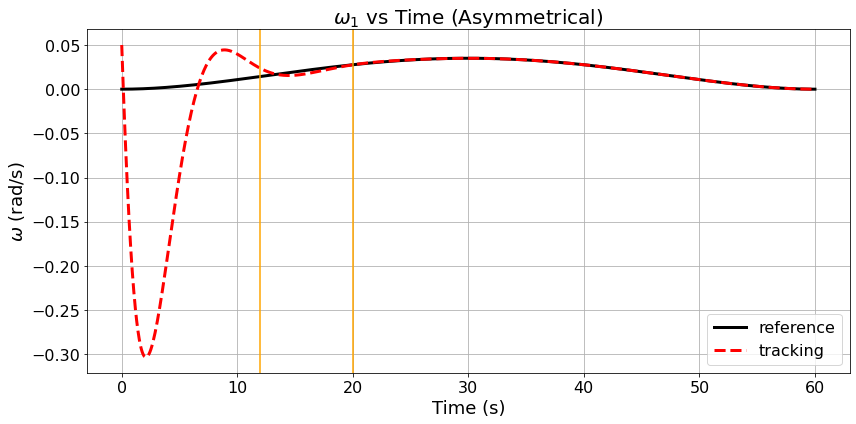

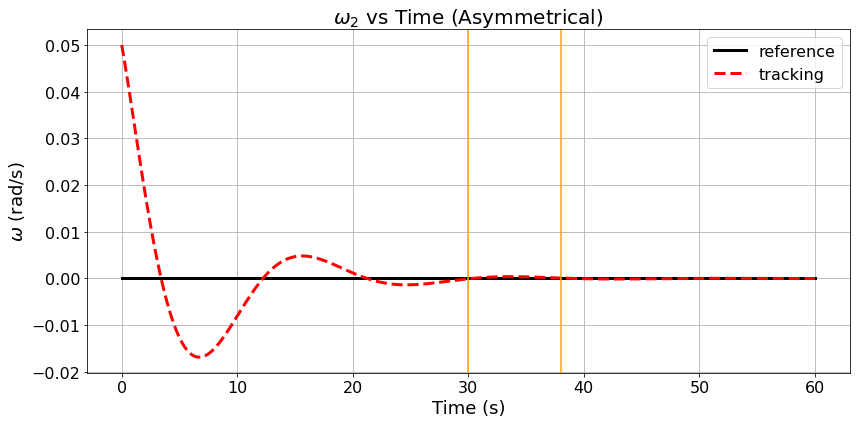

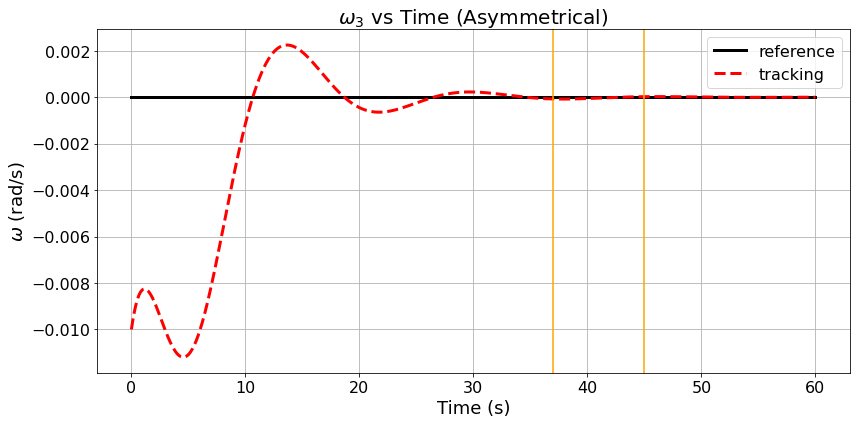

In [15]:
time = X.t
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\omega_1$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, w1star_list, color = 'k', linewidth = '3', label = 'reference')
plt.plot(time, w1, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 12, color = 'orange')
plt.axvline(x = 20, color = 'orange')
plt.ylabel(r'$\omega$ (rad/s)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('w1_proj_asym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\omega_2$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, w2star_list, color = 'k', linewidth = '3', label = 'reference')
plt.plot(time, w2, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 30, color = 'orange')
plt.axvline(x = 38, color = 'orange')
plt.ylabel(r'$\omega$ (rad/s)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('w2_proj_asym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\omega_3$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, w3star_list, color = 'k', linewidth = '3', label = 'reference')
plt.plot(time, w3, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 37, color = 'orange')
plt.axvline(x = 45, color = 'orange')
plt.ylabel(r'$\omega$ (rad/s)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('w3_proj_asym.png')

## Attitude Parameter Graphs Asymm

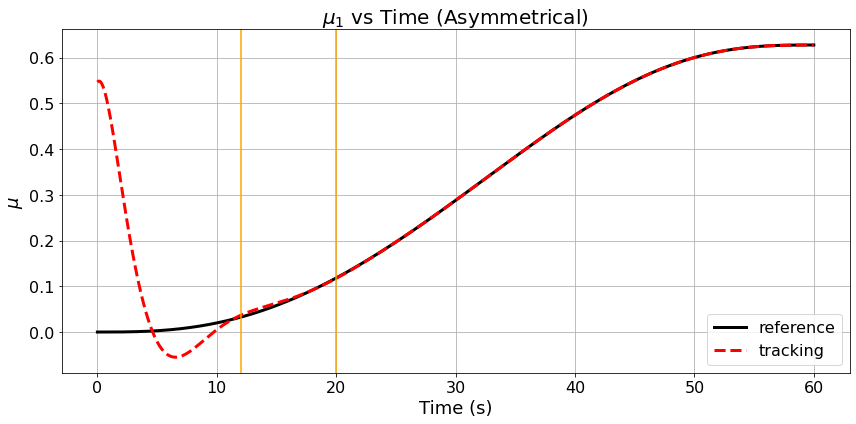

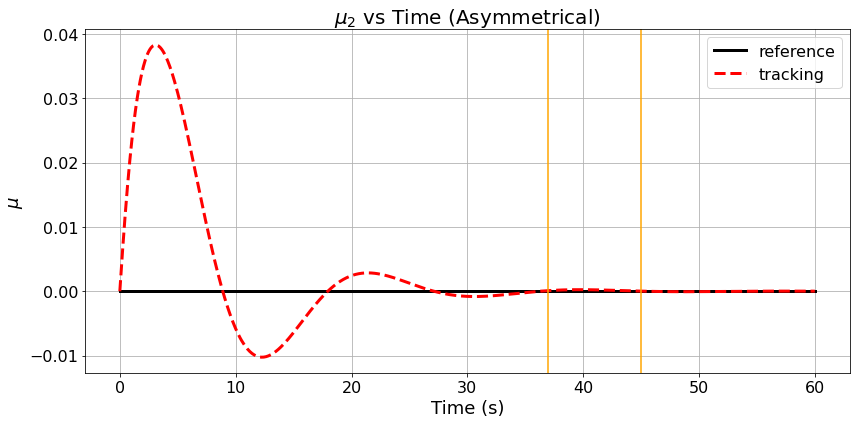

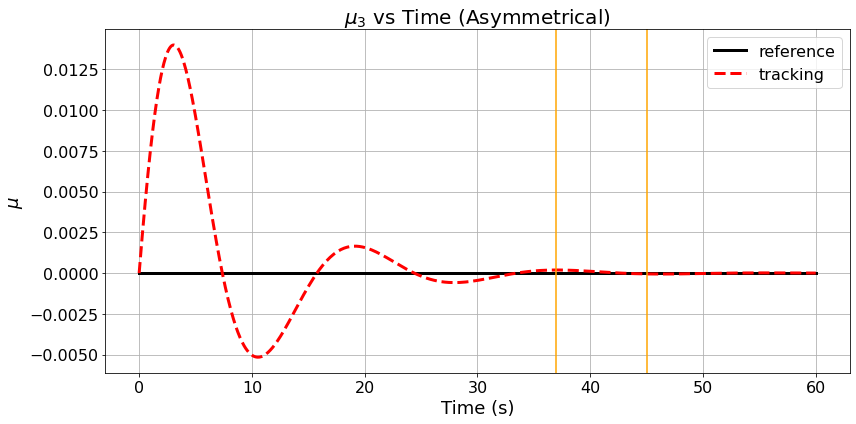

In [16]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\mu_1$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, mu1s_list, color = 'k', linewidth = '3', label = 'reference')
plt.plot(time, mu1, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 12, color = 'orange')
plt.axvline(x = 20, color = 'orange')
plt.ylabel(r'$\mu$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('mu1_proj_asym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\mu_2$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, mu2s_list, color = 'k', linewidth = '3', label = 'reference')
plt.plot(time, mu2, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 37, color = 'orange')
plt.axvline(x = 45, color = 'orange')
plt.ylabel(r'$\mu$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('mu2_proj_asym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\mu_3$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, mu3s_list, color = 'k', linewidth = '3', label = 'reference')
plt.plot(time, mu3, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 37, color = 'orange')
plt.axvline(x = 45, color = 'orange')
plt.ylabel(r'$\mu$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('mu3_proj_asym.png')

## Control Graphs Asymm

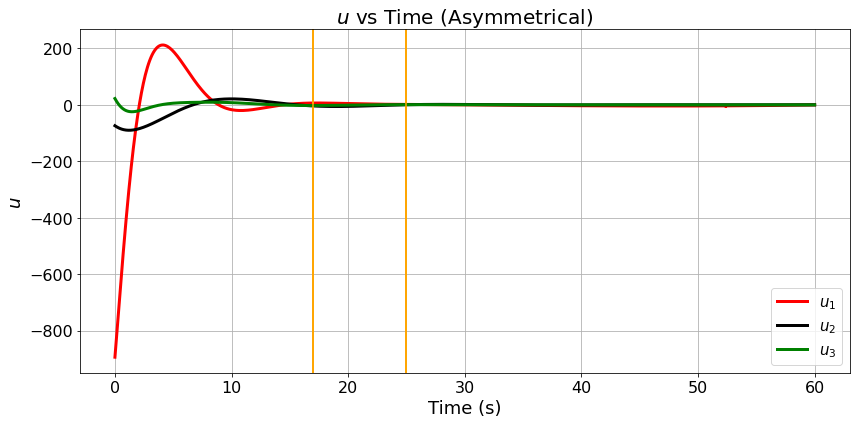

In [17]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$u$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, u1_list, color = 'r', linewidth = '3', label = r'$u_1$')
plt.axvline(x = 17, color = 'orange')
plt.axvline(x = 25, color = 'orange')
plt.ylabel(r'$u$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.plot()

plt.plot(time, u2_list, color = 'k', linewidth = '3', label = r'$u_2$')
plt.axvline(x = 17, color = 'orange')
plt.axvline(x = 25, color = 'orange')
plt.ylabel(r'$u$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.plot()

plt.plot(time, u3_list, color = 'g', linewidth = '3', label = r'$u_3$')
plt.axvline(x = 17, color = 'orange')
plt.axvline(x = 25, color = 'orange')
plt.ylabel(r'$u$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('Cont_proj_asym.png')

## Lyapunov Function Graph Asymm

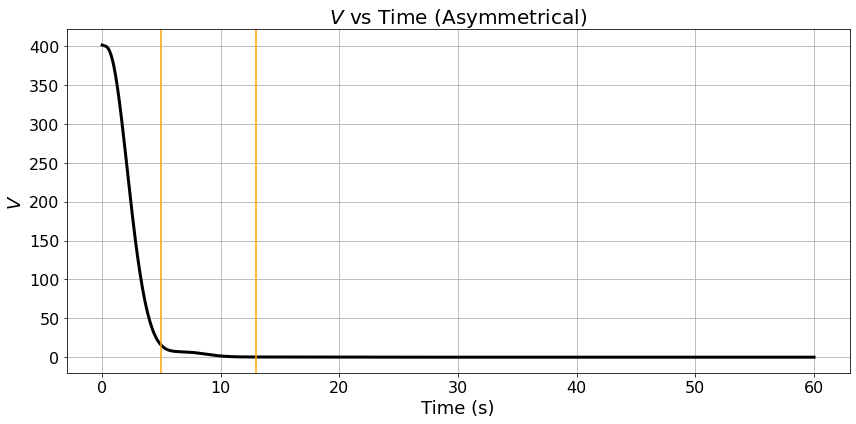

In [18]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$V$ vs Time (Asymmetrical)', fontsize = 20)
plt.plot(time, v_list, color = 'k', linewidth = '3')
plt.axvline(x = 5, color = 'orange')
plt.axvline(x = 13, color = 'orange')
plt.ylabel(r'$V$', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('Lyap_proj_asym.png')

## Wheel Configurations Asymm

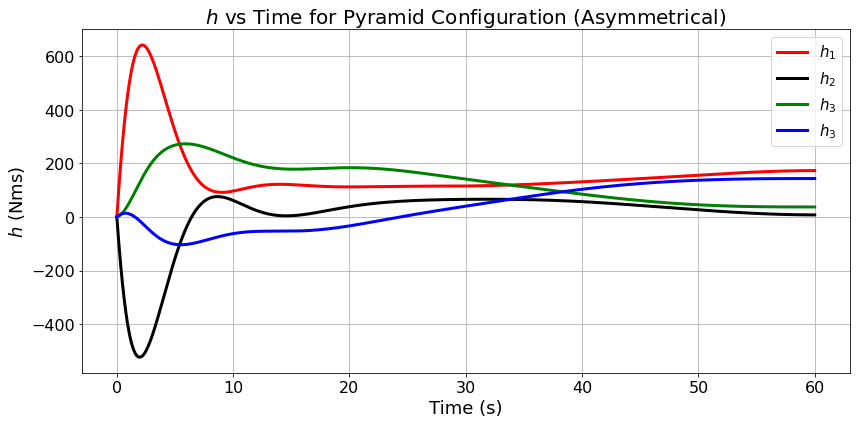

In [19]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$h$ vs Time for Pyramid Configuration (Asymmetrical)', fontsize = 20)
plt.plot(time, h1_pyr, color = 'r', linewidth = '3', label = r'$h_1$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(time, h2_pyr, color = 'k', linewidth = '3', label = r'$h_2$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(time, h3_pyr, color = 'g', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(time, h4_pyr, color = 'b', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ (Nms)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('h_pyr_proj_asym.png')

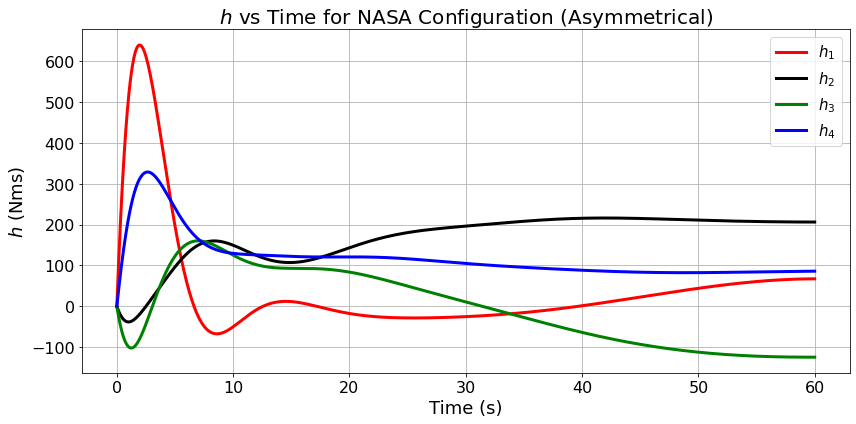

In [20]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$h$ vs Time for NASA Configuration (Asymmetrical)', fontsize = 20)
plt.plot(time, h1_nasa, color = 'r', linewidth = '3', label = r'$h_1$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(time, h2_nasa, color = 'k', linewidth = '3', label = r'$h_2$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(time, h3_nasa, color = 'g', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(time, h4_nasa, color = 'b', linewidth = '3', label = r'$h_4$')
plt.ylabel(r'$h$ (Nms)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('h_NASA_proj_asym.png')

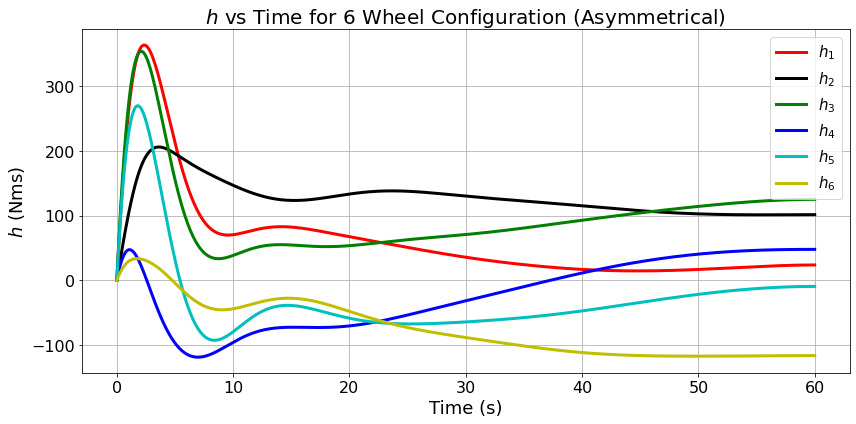

In [21]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$h$ vs Time for 6 Wheel Configuration (Asymmetrical)', fontsize = 20)
plt.plot(time, h1_6w, color = 'r', linewidth = '3', label = r'$h_1$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(time, h2_6w, color = 'k', linewidth = '3', label = r'$h_2$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(time, h3_6w, color = 'g', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(time, h4_6w, color = 'b', linewidth = '3', label = r'$h_4$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(time, h5_6w, color = 'c', linewidth = '3', label = r'$h_5$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(time, h6_6w, color = 'y', linewidth = '3', label = r'$h_6$')
plt.ylabel(r'$h$ (Nms)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('h_6w_proj_asym.png')

## Norm of H Asymm at t0 (initial time) and tf (final time) for all Configs

In [22]:
# Initial s/c ang mom
H_0 = np.linalg.norm(J@w0)
print('H(t_0) (Nms) = ', H_0)

# Final s/c ang mom
wf = np.array([w1[-1], w2[-1], w3[-1]])
H_f = np.linalg.norm(J@wf)
print('H(t_f) (Nms) = ', H_f)

# Final ang mom of 6 wheel
hf_6 = np.array([h1_6w[-1], h2_6w[-1], h3_6w[-1], h4_6w[-1], h5_6w[-1], h6_6w[-1]])
h_f_6 = np.linalg.norm(hf_6)
print('h_6(t_f) (Nms) = ', h_f_6)

# Final ang mom of NASA config
hf_nasa = np.array([h1_nasa[-1], h2_nasa[-1], h3_nasa[-1], h4_nasa[-1],])
h_f_nasa = np.linalg.norm(hf_nasa)
print('h_nasa(t_f) (Nms) = ', h_f_nasa)

# Final ang mom of Pyramid config
hf_pyr = np.array([h1_pyr[-1], h2_pyr[-1], h3_pyr[-1], h4_pyr[-1],])
h_f_pyr = np.linalg.norm(hf_pyr)
print('h_pyr(t_f) (Nms) = ', h_f_pyr)

H(t_0) (Nms) =  291.0859957787583
H(t_f) (Nms) =  0.0483072720021032
h_6(t_f) (Nms) =  205.8588614761167
h_nasa(t_f) (Nms) =  264.5294969401098
h_pyr(t_f) (Nms) =  228.0725353960174


# <center>Symmetric Configuration Results<center>

In [23]:
# Integrator function
def func_s(t, x):
    mu = x[0:3]
    w = x[3:6]
    h = x[6:9]

    # Polynomial Curves
    phi = mu_poly(t, t_f, angle)
    phi_dot = mu_dot_poly(t, t_f, angle)
    phi_2dot = mu_2dot_poly(t, t_f, angle)

    # Reference state variables for trajectory
    mu_star = np.tan(phi / 2) * e
    w_star = phi_dot * e
    w_dot_star = phi_2dot * e
    w_cross = skew_mat(w)

    # Error
    A_error = g2A(mu) @ g2A(mu_star).T
    mu_error = A2g(A_error)

    # Control 
    u = -P @ (w - R @ w_star) + w_cross @ Js @ w - Js @ w_cross @ R @ w_star + Js @ R @ w_dot_star - k * mu_error

    # mu_dot and w_dot, h_dot EOM
    mu_cross = skew_mat(mu)
    mu_dot = 0.5 * ((1 + np.linalg.norm(mu) ** 2) * np.eye(3) + mu_cross + mu_cross @ mu_cross) @ w
    w_dot = np.linalg.inv(Js) @ (u - np.cross(w, Js @ w))
    h_dot = -w_cross@h - u

    return list(np.concatenate((mu_dot, w_dot, h_dot)))

In [24]:
# Solve
Xs = solve_ivp(func_s, [0, t_f], x0,  method='RK45', rtol=1e-10, atol=1e-10)

In [25]:
# Extract results and initialize lists
times = Xs.t

mu1s = Xs.y[0]
mu2s = Xs.y[1]
mu3s = Xs.y[2]

w1s = Xs.y[3]
w2s = Xs.y[4]
w3s = Xs.y[5]

h1s = Xs.y[6]
h2s = Xs.y[7]
h3s = Xs.y[8]

w1star_lists=[]
w2star_lists=[]
w3star_lists=[]

mu1s_lists=[]
mu2s_lists=[]
mu3s_lists=[]

u1_lists=[]
u2_lists=[]
u3_lists=[]

v_lists=[]

h1_nasas = []
h2_nasas = []
h3_nasas = []
h4_nasas = []

h1_pyrs = []
h2_pyrs = []
h3_pyrs = []
h4_pyrs = []

h1_6ws = []
h2_6ws = []
h3_6ws = []
h4_6ws = []
h5_6ws = []
h6_6ws = []

In [26]:
# Get reference to graph
for i in range(len(Xs.t)):
    times = Xs.t[i]
    mus = np.array([Xs.y[0][i], Xs.y[1][i], Xs.y[2][i]])
    ws = np.array([Xs.y[3][i], Xs.y[4][i], Xs.y[5][i]])
    hs = np.array([Xs.y[6][i], Xs.y[7][i], Xs.y[8][i]])

    # Polynomial Curves
    phi = mu_poly(times, t_f, angle)
    phi_dot = mu_dot_poly(times, t_f, angle)
    phi_2dot= mu_2dot_poly(times, t_f, angle)

    # Ref variables for traj
    mu_star = np.tan(phi / 2) * e
    w_star = phi_dot * e
    w_dot_star = phi_2dot * e
    w_cross_s = skew_mat(ws)

    # error
    A_errors = g2A(mus) @ g2A(mu_star).T
    mu_errors = A2g(A_errors)

    # Control 
    us = -P @ (ws - R @ w_star) + w_cross_s @ Js @ ws - Js @ w_cross_s @ R @ w_star + Js @ R @ w_dot_star - k * mu_errors

    # Lyapunov function
    eps_s = ws - w_star
    vs = 0.5 * eps_s.T @ Js @ eps_s + k*np.log(1 + np.inner(mu_errors, mu_errors))
    
    # Compute RW momenta in w.f.
    H_W_Ns = W_N_inv@hs
    H_W_6s = W_6_inv@hs
    H_W_4s = W_4_inv@hs

    w1star_lists.append(w_star[0])
    w2star_lists.append(w_star[1])
    w3star_lists.append(w_star[2])
    mu1s_lists.append(mu_star[0])
    mu2s_lists.append(mu_star[1])
    mu3s_lists.append(mu_star[2])
    u1_lists.append(us[0])
    u2_lists.append(us[1])
    u3_lists.append(us[2])
    v_lists.append(vs)
    h1_nasas.append(H_W_Ns[0]) 
    h2_nasas.append(H_W_Ns[1])  
    h3_nasas.append(H_W_Ns[2])  
    h4_nasas.append(H_W_Ns[3])  
    h1_6ws.append(H_W_6s[0]) 
    h2_6ws.append(H_W_6s[1])  
    h3_6ws.append(H_W_6s[2])  
    h4_6ws.append(H_W_6s[3]) 
    h5_6ws.append(H_W_6s[4])  
    h6_6ws.append(H_W_6s[5]) 
    h1_pyrs.append(H_W_4s[0]) 
    h2_pyrs.append(H_W_4s[1])  
    h3_pyrs.append(H_W_4s[2])  
    h4_pyrs.append(H_W_4s[3]) 

## Angular Momentum Symm

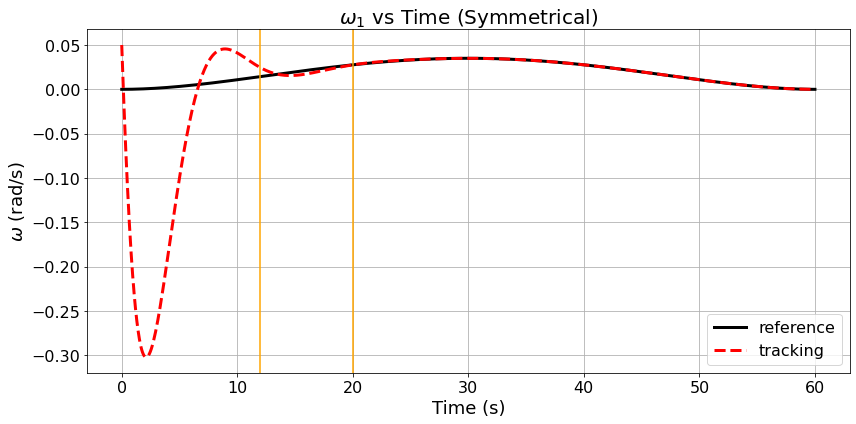

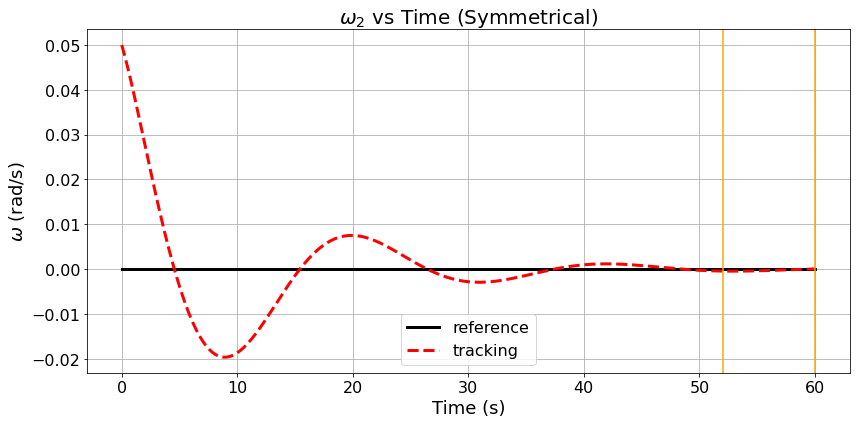

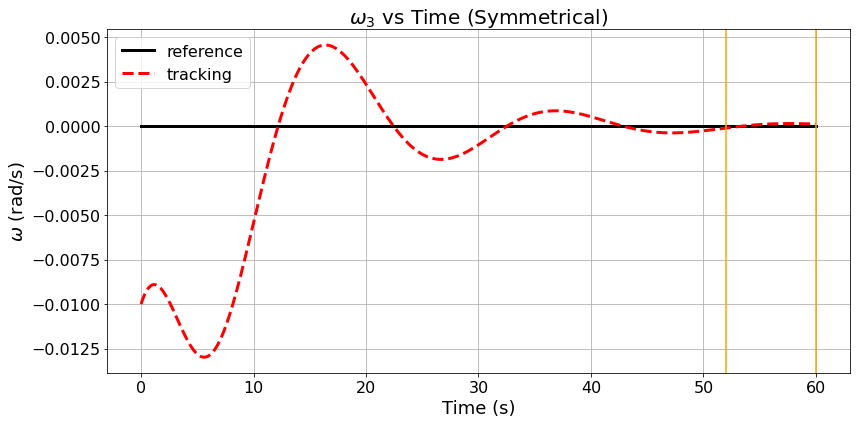

In [27]:
times = Xs.t
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\omega_1$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, w1star_lists, color = 'k', linewidth = '3', label = 'reference')
plt.plot(times, w1s, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 12, color = 'orange')
plt.axvline(x = 20, color = 'orange')
plt.ylabel(r'$\omega$ (rad/s)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('w1_proj_sym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\omega_2$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, w2star_lists, color = 'k', linewidth = '3', label = 'reference')
plt.plot(times, w2s, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 52, color = 'orange')
plt.axvline(x = 60, color = 'orange')
plt.ylabel(r'$\omega$ (rad/s)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('w2_proj_sym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\omega_3$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, w3star_lists, color = 'k', linewidth = '3', label = 'reference')
plt.plot(times, w3s, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 52, color = 'orange')
plt.axvline(x = 60, color = 'orange')
plt.ylabel(r'$\omega$ (rad/s)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('w3_proj_sym.png')

## Attitude Parameter Graphs Symm

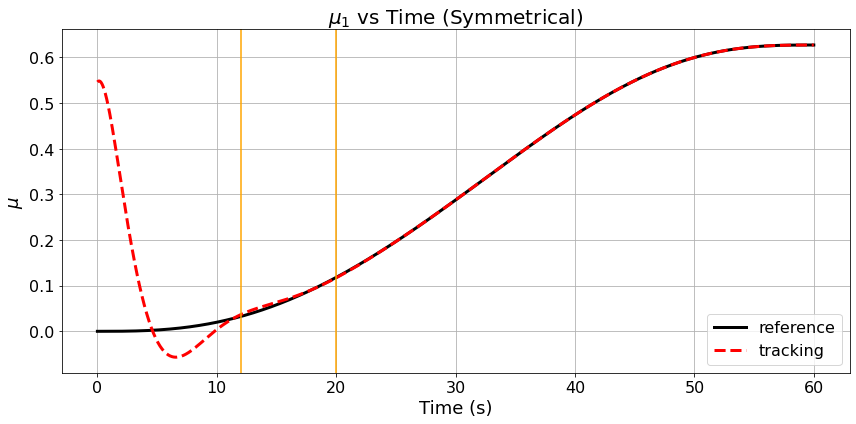

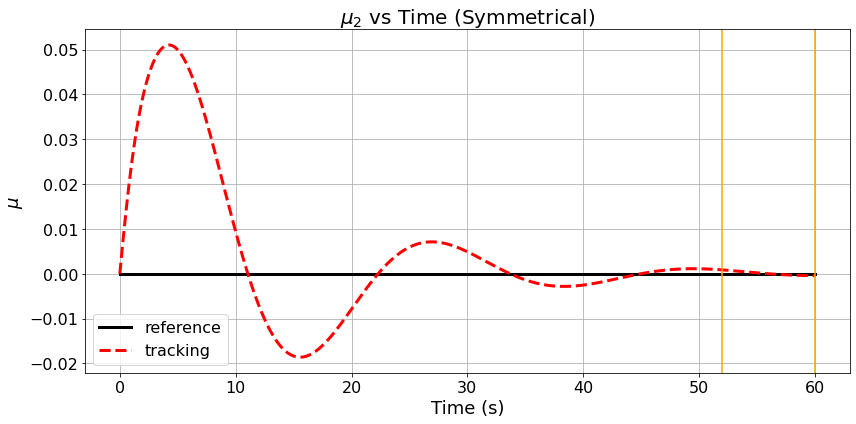

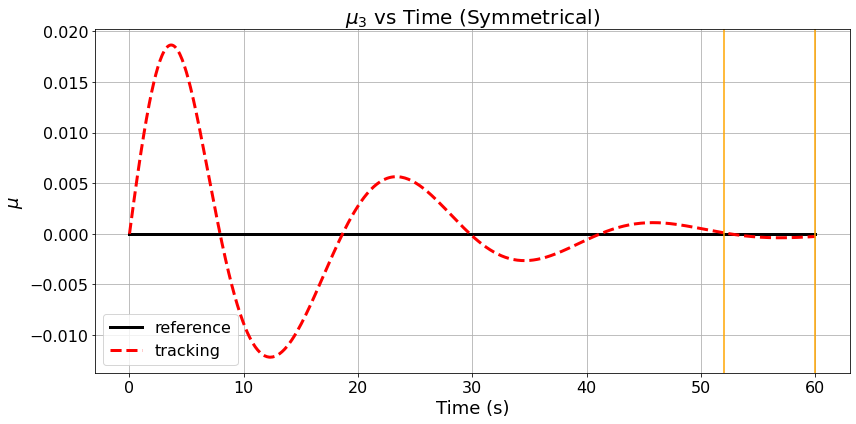

In [28]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\mu_1$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, mu1s_lists, color = 'k', linewidth = '3', label = 'reference')
plt.plot(times, mu1s, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 12, color = 'orange')
plt.axvline(x = 20, color = 'orange')
plt.ylabel(r'$\mu$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('mu1_proj_sym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\mu_2$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, mu2s_lists, color = 'k', linewidth = '3', label = 'reference')
plt.plot(times, mu2s, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 52, color = 'orange')
plt.axvline(x = 60, color = 'orange')
plt.ylabel(r'$\mu$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('mu2_proj_sym.png')

fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$\mu_3$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, mu3s_lists, color = 'k', linewidth = '3', label = 'reference')
plt.plot(times, mu3s, linewidth = '3', linestyle = '--', color = 'red', label='tracking')
plt.axvline(x = 52, color = 'orange')
plt.axvline(x = 60, color = 'orange')
plt.ylabel(r'$\mu$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('mu3_proj_sym.png')

## Control Symm

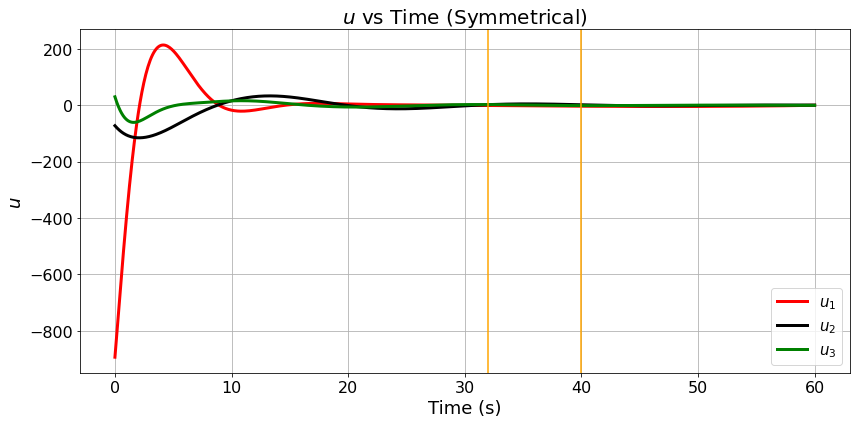

In [29]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$u$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, u1_lists, color = 'r', linewidth = '3', label = r'$u_1$')
plt.ylabel(r'$u$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.plot()

plt.plot(times, u2_lists, color = 'k', linewidth = '3', label = r'$u_2$')
plt.ylabel(r'$u$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.plot()

plt.plot(times, u3_lists, color = 'g', linewidth = '3', label = r'$u_3$')
plt.axvline(x = 32, color = 'orange')
plt.axvline(x = 40, color = 'orange')
plt.ylabel(r'$u$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('Cont_proj_sym.png')

## Lyapunov Function Graph Symm

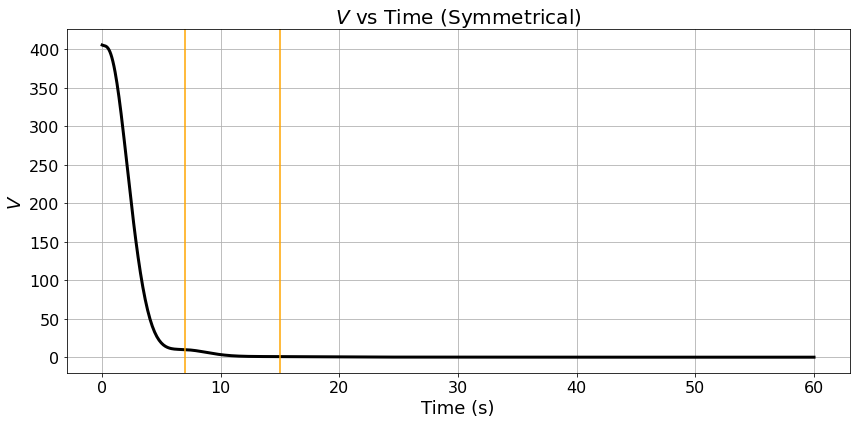

In [30]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$V$ vs Time (Symmetrical)', fontsize = 20)
plt.plot(times, v_lists, color = 'k', linewidth = '3')
plt.axvline(x = 7, color = 'orange')
plt.axvline(x = 15, color = 'orange')
plt.ylabel(r'$V$', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.plot()
plt.savefig('Lyap_proj_sym.png')

## Wheel Configurations Symm

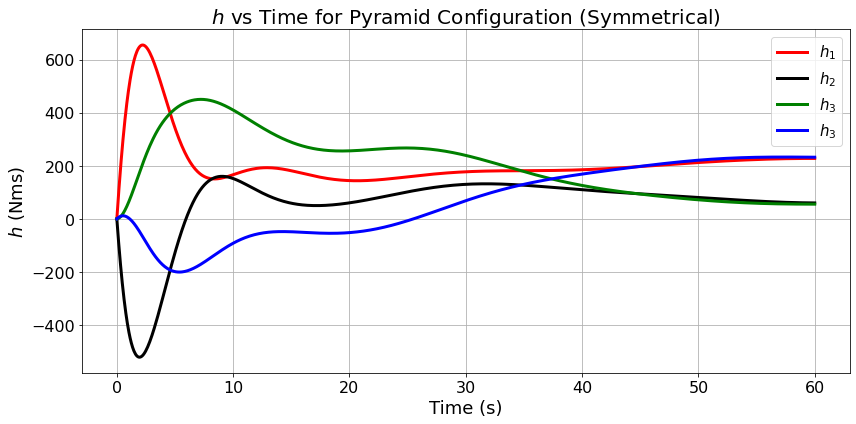

In [31]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$h$ vs Time for Pyramid Configuration (Symmetrical)', fontsize = 20)
plt.plot(times, h1_pyrs, color = 'r', linewidth = '3', label = r'$h_1$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(times, h2_pyrs, color = 'k', linewidth = '3', label = r'$h_2$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(times, h3_pyrs, color = 'g', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(times, h4_pyrs, color = 'b', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ (Nms)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('h_pyr_proj_sym.png')

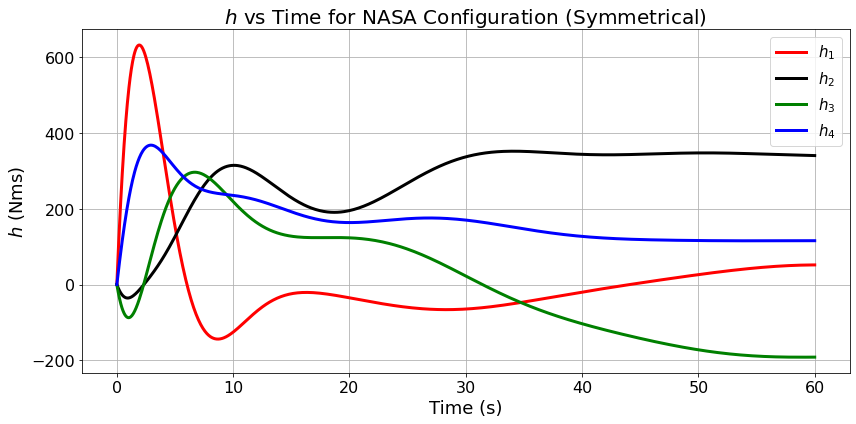

In [32]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$h$ vs Time for NASA Configuration (Symmetrical)', fontsize = 20)
plt.plot(times, h1_nasas, color = 'r', linewidth = '3', label = r'$h_1$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(times, h2_nasas, color = 'k', linewidth = '3', label = r'$h_2$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(times, h3_nasas, color = 'g', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(times, h4_nasas, color = 'b', linewidth = '3', label = r'$h_4$')
plt.ylabel(r'$h$ (Nms)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('h_NASA_proj_sym.png')

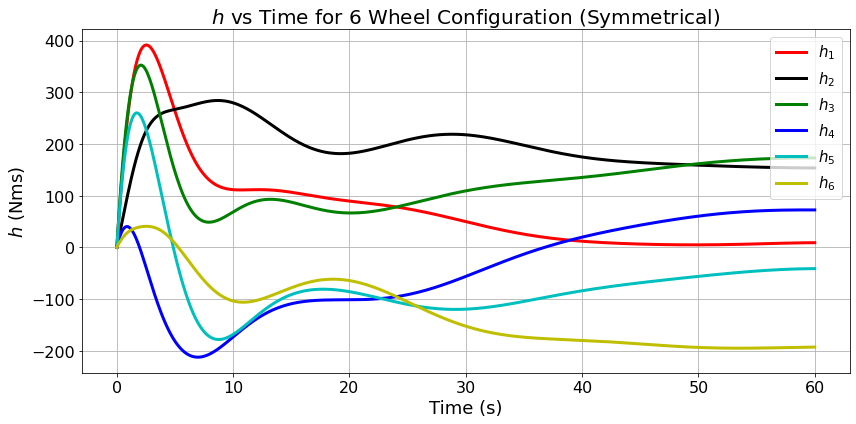

In [33]:
fig = plt.figure(figsize =(12,6), tight_layout = True)
plt.title(r'$h$ vs Time for 6 Wheel Configuration (Symmetrical)', fontsize = 20)
plt.plot(times, h1_6ws, color = 'r', linewidth = '3', label = r'$h_1$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(times, h2_6ws, color = 'k', linewidth = '3', label = r'$h_2$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.plot(times, h3_6ws, color = 'g', linewidth = '3', label = r'$h_3$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(times, h4_6ws, color = 'b', linewidth = '3', label = r'$h_4$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(times, h5_6ws, color = 'c', linewidth = '3', label = r'$h_5$')
plt.ylabel(r'$h$ ', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)

plt.plot(times, h6_6ws, color = 'y', linewidth = '3', label = r'$h_6$')
plt.ylabel(r'$h$ (Nms)', fontsize = 18)
plt.xlabel('Time (s)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 15)
plt.grid()
plt.plot()
plt.savefig('h_6w_proj_sym.png')

## Norm of H Symm for t0 (initial time) and tf (final time) for all Configs

In [34]:
# Initial s/c ang mom
H_0s = np.linalg.norm(Js@w0)
print('H(t_0) (Nms) = ', H_0s)

# Final s/c ang mom
wfs = np.array([w1s[-1], w2s[-1], w3s[-1]])
H_fs = np.linalg.norm(Js@wfs)
print('H(t_f) (Nms) = ', H_fs)

# Final ang mom of 6 wheel
hf_6s = np.array([h1_6ws[-1], h2_6ws[-1], h3_6ws[-1], h4_6ws[-1], h5_6ws[-1], h6_6ws[-1]])
h_f_6s = np.linalg.norm(hf_6s)
print('h_6(t_f) (Nms) = ', h_f_6s)

# Final ang mom of NASA config
hf_nasas = np.array([h1_nasas[-1], h2_nasas[-1], h3_nasas[-1], h4_nasas[-1],])
h_f_nasas = np.linalg.norm(hf_nasas)
print('h_nasa(t_f) (Nms) = ', h_f_nasas)

# Final ang mom of Pyramid config
hf_pyrs = np.array([h1_pyrs[-1], h2_pyrs[-1], h3_pyrs[-1], h4_pyrs[-1],])
h_f_pyrs = np.linalg.norm(hf_pyrs)
print('h_pyr(t_f) (Nms) = ', h_f_pyrs)

H(t_0) (Nms) =  442.1370190183204
H(t_f) (Nms) =  0.9294911325516224
h_6(t_f) (Nms) =  312.588842567761
h_nasa(t_f) (Nms) =  410.70065139628366
h_pyr(t_f) (Nms) =  335.4666752068295
